In [51]:
### Function Imports
from AdvPairsFunctions import import_fx_data, plot_forex, daily_returns, get_beta, beta_backtest, performance_metrics

In [52]:
### Call Function to Load in Rate Data
forex_pairs = ['EURUSD=X', 'GBPUSD=X']
start_date = '2019-01-01'
forex_data = import_fx_data(forex_pairs, start_date)
forex_data.tail()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,EURUSD=X,GBPUSD=X
1423,2024-06-17,1.070217,1.268311
1424,2024-06-18,1.074068,1.271600
1425,2024-06-19,1.074229,1.270745
1426,2024-06-20,1.075153,1.272200
1427,2024-06-21,1.069747,1.266047


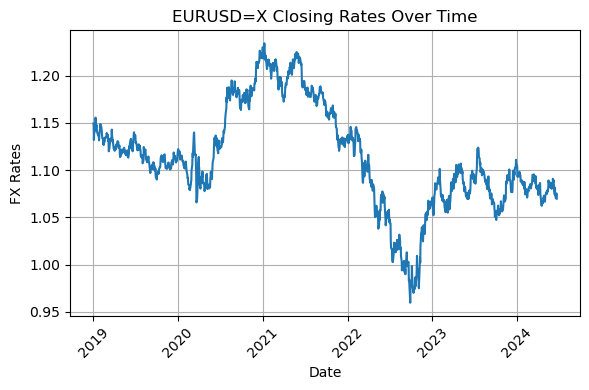

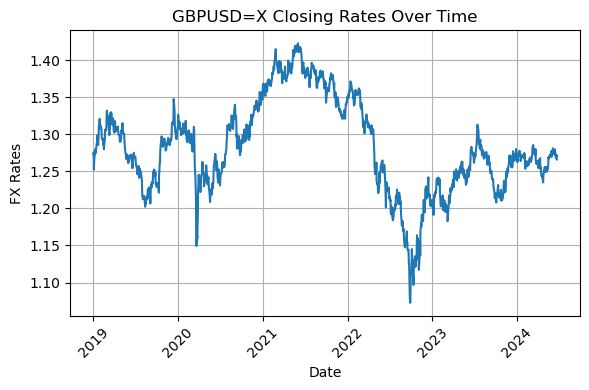

In [53]:
### Return Function to Plot FX Pairs
plot_forex(forex_data, forex_pairs)


In [54]:
### Call Function to Calculate Daily Returns
daily_rets = daily_returns(forex_data)
print(daily_rets.head())


        Date  EURUSD=X  GBPUSD=X
0 2019-01-02 -0.002728  0.001275
1 2019-01-03 -0.012529 -0.018219
2 2019-01-04  0.006447  0.008537
3 2019-01-07  0.001700  0.008405
4 2019-01-08  0.006073  0.004015


In [55]:
### Function Call to Compute Beta
'''
Beta is a measure of the sensitivity or volatility of an asset's returns in relation 
to the returns of a benchmark or market index. In the context of foreign exchange (FX) 
trading, beta represents how much the returns of one currency pair move in relation to 
the returns of another currency pair.
Beta = 1: The returns of the currency pair move in tandem with the benchmark. If the 
          benchmark's return increases by 1%, the currency pair's return also increases 
          by 1%, on average.

Beta > 1: The currency pair is more volatile than the benchmark. For example, if beta 
          is 1.5, then the currency pair's return is expected to increase by 1.5% for 
          every 1% increase in the benchmark's return, on average.

Beta < 1: The currency pair is less volatile than the benchmark. For example, if beta is 
          0.5, then the currency pair's return is expected to increase by 0.5% for every 
          1% increase in the benchmark's return, on average.

Beta = 0: There is no relationship between the currency pair's returns and the benchmark's returns.

Negative Beta: The currency pair moves in the opposite direction of the benchmark. For 
               example, if beta is -1, then the currency pair's return is expected to decrease
               by 1% for every 1% increase in the benchmark's return, on average.
'''
base_pair = 'EURUSD=X'
benchmark_pair = 'GBPUSD=X'
beta = get_beta(daily_rets, base_pair, benchmark_pair)
print('The computed Beta value is:', round(beta, 6))


The computed Beta value is: 0.524974


In [56]:
### Function Call to return Hedged and Unhedged Cumulative Returns
# Set value of Long Position
long_pos = 1000  
short_pos, hedged_cumulative_rets, unhedged_cumulative_rets = beta_backtest(long_pos, base_pair, benchmark_pair, daily_rets, beta)
print("Long Position Size: ", long_pos)
print("Short Position Size: ", round(short_pos, 4))
print("Recent Hedged Cumulative Returns: ", hedged_cumulative_rets)
print("Recent Unhedged Cumulative Returns: ", unhedged_cumulative_rets)


Long Position Size:  1000
Short Position Size:  -524.9745
Recent Hedged Cumulative Returns:  0       996.602548
1       993.648208
2       995.601291
3       992.900930
4       996.837891
           ...    
1422    927.727430
1423    929.802756
1424    930.270736
1425    930.511741
1426    928.195714
Length: 1427, dtype: float64
Recent Unhedged Cumulative Returns:  0       997.272090
1       984.777122
2       991.126306
3       992.811387
4       998.840483
           ...    
1422    931.184999
1423    934.535557
1424    934.676101
1425    935.480057
1426    930.776538
Name: EURUSD=X, Length: 1427, dtype: float64


In [57]:
### Return Performance Metrics
performance_metrics(long_pos, hedged_cumulative_rets, unhedged_cumulative_rets, daily_rets)


Metric                                  Hedged        Unhedged
Total Returns                         -71.8043        -69.2235
Annualized Returns                         nan             nan
Mean Return                           961.1472        968.5310
Standard Deviation                     28.7449         47.7714
Sharpe Ratio                          530.7977        321.8445

The Sharpe ratio measures the risk-adjusted return of an investment.
In this instance, the hedged strategy has a Sharpe ratio of 530.7977,
which means for every unit of risk, the hedged portfolio is generating 530.7977 units of return above the risk-free rate.
The unhedged strategy has a Sharpe ratio of 321.8445,
indicating that for every unit of risk, the unhedged portfolio is generating 321.8445 units of return above the risk-free rate.
A higher Sharpe ratio typically indicates a more favorable risk-adjusted return.
